In [1]:
import numpy as np #<>
from skimage import io, img_as_float
from skimage.filters import threshold_otsu
from skimage.restoration import denoise_nl_means, estimate_sigma
from scipy.ndimage import convolve, generic_filter
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import os

# 1) Lee Filter and Frost Filter for Reducing Speckle Noise

In [2]:
def lee_filter(image):
    sigma_est = np.mean(estimate_sigma(image, channel_axis=None))
    denoised_img = denoise_nl_means(image, h=1.15*sigma_est, fast_mode=True, patch_size=7, patch_distance=11, channel_axis=None)
    return denoised_img


def frost_filter(image, damping_factor=2.0, win_size=7):
    mean_kernel = np.ones((win_size, win_size))/(win_size ** 2)
    local_mean = convolve(image, mean_kernel, mode='reflect')
    local_var = generic_filter(image, np.var, size=win_size, mode='reflect')
    weights = np.exp(-damping_factor * np.sqrt(local_var)/local_mean)
    weighted_mean = convolve(image * weights, mean_kernel, mode='reflect')
    normalization = convolve(weights, mean_kernel, mode='reflect')
    return weighted_mean/normalization

## <font color="#C70039">Example</font>

CPU times: total: 1.83 s
Wall time: 1.92 s


(-0.5, 399.5, 399.5, -0.5)

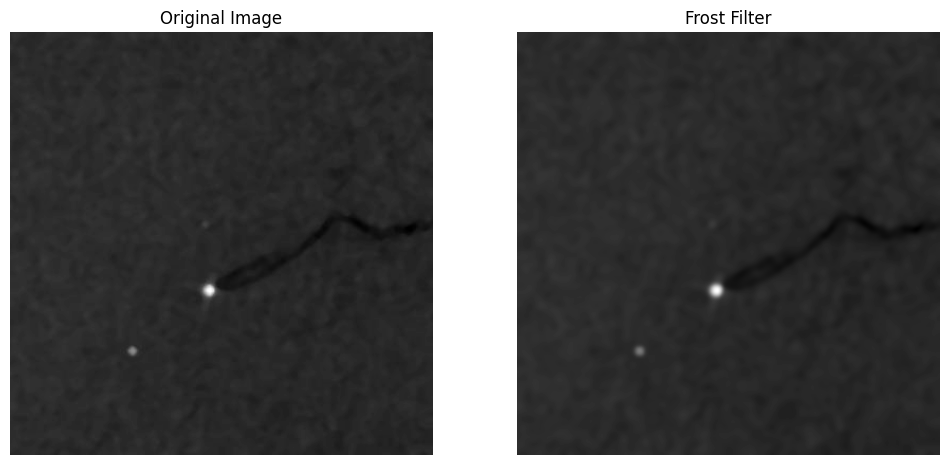

In [3]:
%%time

path = r"C:\Users\bassi\ARIAS\OSD\Data\SAR images\alldata\data - Copy\1\1_0023.jpeg"
original = io.imread(path, as_gray=True)/255.0

frost = frost_filter(original.copy())

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(original, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(122)
plt.imshow(frost, cmap='gray')
plt.title('Frost Filter')
plt.axis('off')

# 2) Removing Bright Dots

In [4]:
# First Method

def rmv_brt1(I, q1, q2): #I is the image's path and q the desired quantile
    
    if isinstance(I, str): #I can be either a path or a np.array
        I = I.replace("\\","/")
        I = io.imread(I, as_gray=True)/255.0    
    
    quantile1 = np.quantile(I, q1)
    quantile2 = np.quantile(I, q2)

    def newval(x):
        if x > quantile1:
            x = quantile2
        return x
    V = np.vectorize(newval)
    
    return V(I)

## <font color="#C70039">Example</font>

CPU times: total: 31.2 ms
Wall time: 45 ms


(-0.5, 399.5, 399.5, -0.5)

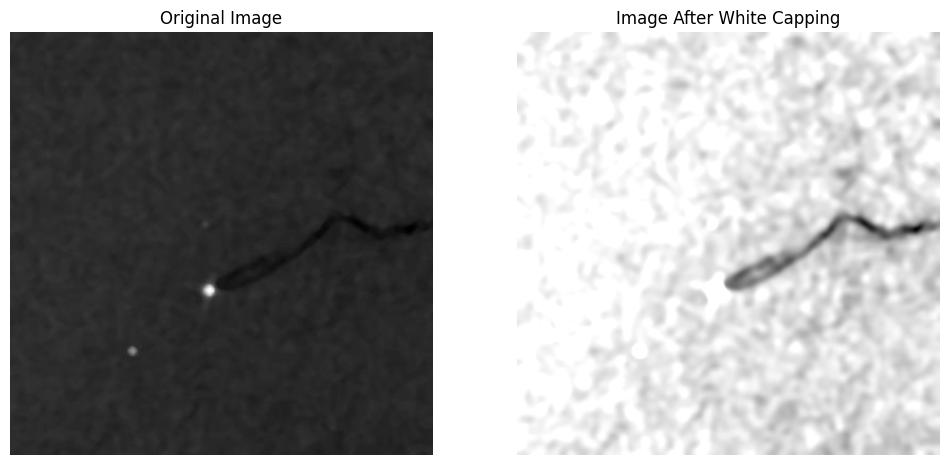

In [5]:
%%time

I1 = rmv_brt1(frost.copy(), 0.8, 0.8)

plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow(original, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(122)
plt.imshow(I1, cmap='gray')
plt.title('Image After White Capping')
plt.axis('off')

In [6]:
# Second Method

def rmv_brt2(I, q, k): # "I" is the image's path and q the desired quantile
    
    if isinstance(I, str): # "I" can be either a path or a np.array
        I = I.replace("\\","/")
        I = io.imread(I, as_gray=True)/255.0
    
    # local correction
    for i in range(0,len(I),k): # using a step
        for j in range(0,len(I),k):
            lclqntl = np.quantile(I[i:i+k,j:j+k], q)
            I[i:i+k,j:j+k] = np.minimum(I[i:i+k,j:j+k], lclqntl)
    
    return I

## <font color="#C70039">Example</font>

CPU times: total: 375 ms
Wall time: 381 ms


(-0.5, 399.5, 399.5, -0.5)

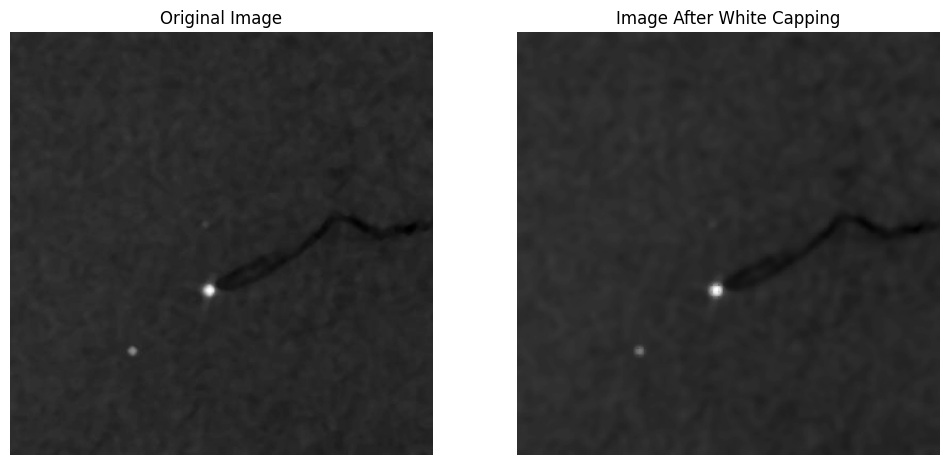

In [7]:
%%time

I2 = rmv_brt2(frost.copy(), 0.8, 5)

plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow(original, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(122)
plt.imshow(I2, cmap='gray')
plt.title('Image After White Capping')
plt.axis('off')

In [8]:
# Third Method

def rmv_brt3(I, q, k): #I is the image's path and q the desired quantile
    
    if isinstance(I, str): #I can be either a path or a np.array
        I = I.replace("\\","/")
        I = io.imread(I, as_gray=True)/255.0
    
    sample = np.random.randint((0,0), 
                               (I.shape[0]-k, I.shape[1]-k), 
                               size=(2*I.shape[0]*I.shape[1]//(k**2), 2))
    for i,j in sample:
        lclqntl = np.quantile(I[i:i+k,j:j+k], q)
        I[i:i+k,j:j+k] = np.minimum(I[i:i+k,j:j+k], lclqntl)
        lclqntl_ = np.quantile(I[i:i+k,j:j+k], 1-q)
        I[i:i+k,j:j+k] = np.maximum(I[i:i+k,j:j+k], lclqntl_)
    return I

## <font color="#C70039">Example</font>

CPU times: total: 4.09 s
Wall time: 4.14 s


(-0.5, 399.5, 399.5, -0.5)

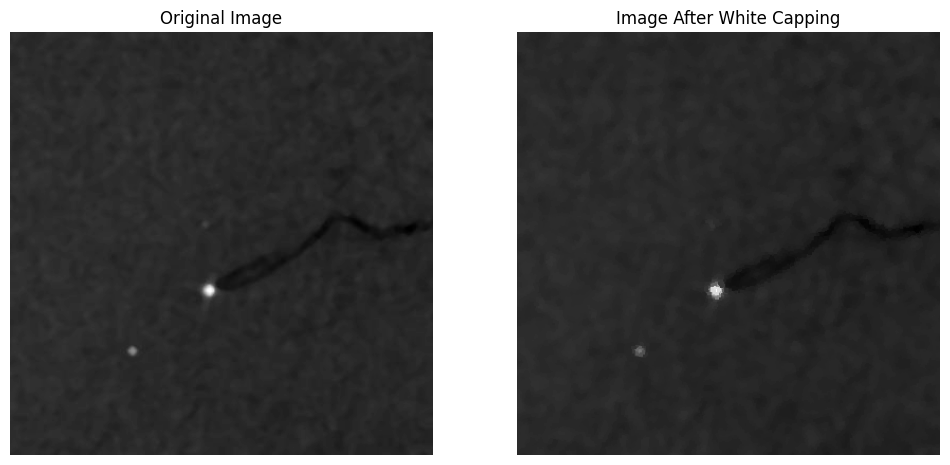

In [10]:
%%time

I3 = rmv_brt3(frost.copy(), 0.5, 3)

plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow(original, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(122)
plt.imshow(I3, cmap='gray')
plt.title('Image After White Capping')
plt.axis('off')

In [39]:
# Fourth Method

def rmv_brt4(I): #I is the image's path and q the desired quantile
    
    if isinstance(I, str): #I can be either a path or a np.array
        I = I.replace("\\","/")
        I = io.imread(I, as_gray=True)/255.0
    
    mu = np.mean(np.unique(I))
    sigma = np.std(np.unique(I))
    I[I>mu+2*sigma] = mu+sigma
#     I[I<mu-2*sigma] = mu-2.5*sigma
    
    return I

## <font color="#C70039">Example</font>

CPU times: total: 31.2 ms
Wall time: 44.4 ms


(-0.5, 399.5, 399.5, -0.5)

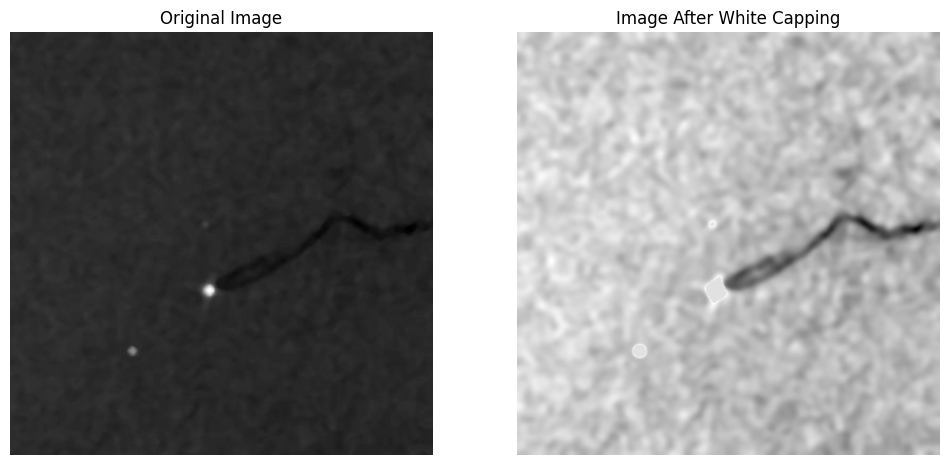

In [40]:
%%time

I4 = rmv_brt4(frost.copy())

plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow(original, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(122)
plt.imshow(I4, cmap='gray')
plt.title('Image After White Capping')
plt.axis('off')

# 3) Image Segmentation

In [11]:
# First Method
def segment(I):
    m = np.min(I)
    M = np.max(I)
    def treshold(x):
        if x <= m + (M-m)*0.5:
            return m + (M-m)*0.2
        else :
            return m + (M-m)*0.8    
    vectorized_function = np.vectorize(treshold)
    R = vectorized_function(I)
    return R

# Second Method
def segment_otsu(image): #image is a path (string)
    if isinstance(image, str): #image can be either a path or a np.array
        image = image.replace("\\","/")
        image = img_as_float(io.imread(image, as_gray=True))
    threshold = threshold_otsu(image)
    binary_image = (image > threshold).astype(np.uint8)
    return binary_image

## <font color="#C70039">Example (First Method)</font>

CPU times: total: 46.9 ms
Wall time: 69.3 ms


(-0.5, 399.5, 399.5, -0.5)

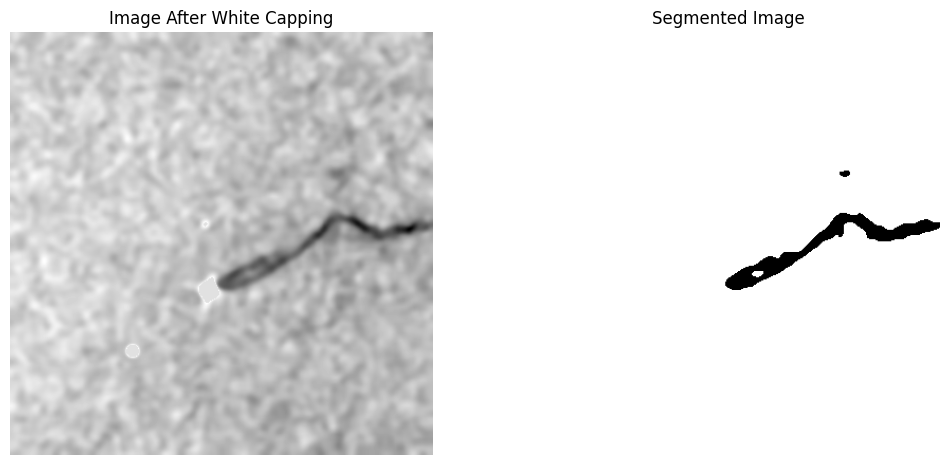

In [31]:
%%time

segmented = segment(I4.copy())

plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow(I4, cmap='gray')
plt.title('Image After White Capping')
plt.axis('off')

plt.subplot(122)
plt.imshow(segmented, cmap='gray')
plt.title('Segmented Image')
plt.axis('off')

## <font color="#C70039">Example (Second Method)</font>

(-0.5, 399.5, 399.5, -0.5)

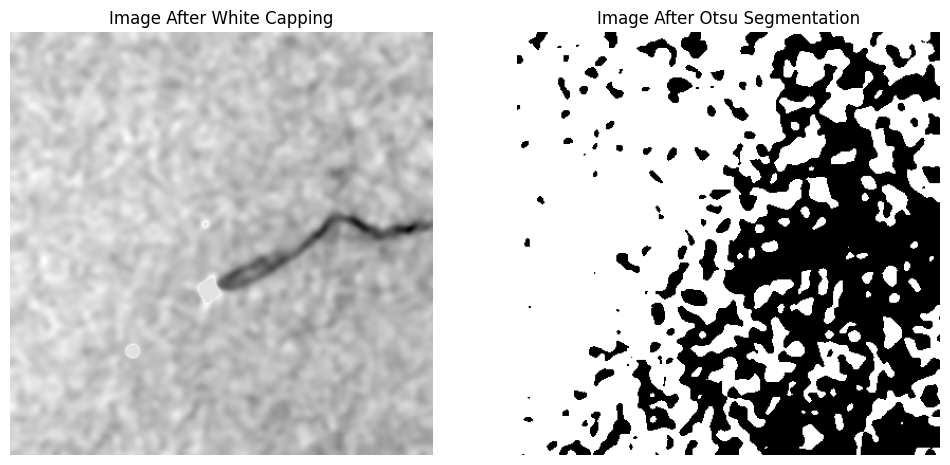

In [32]:
# I = r"C:\Users\bassi\ARIAS\OSD\Data\SAR images\alldata\data - Copy\1\1_0027.jpeg"
# original = io.imread(I, as_gray=True)/255.0

OS = segment_otsu(I4.copy())

plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow(I4, cmap='gray')
plt.title('Image After White Capping')
plt.axis('off')

plt.subplot(122)
plt.imshow(OS, cmap='gray')
plt.title('Image After Otsu Segmentation')
plt.axis('off')

# 4) Edge Detection Using a Segmented Image's Gradient 

In [33]:
def edge(A):
    
    if isinstance(A, str): # "A" can be either a path or a np.array
        A = A.replace("\\","/")
        A = img_as_float(io.imread(A, as_gray=True))  
        
    G = np.zeros(A.shape, dtype=np.float64)  # Use float64 for intermediate calculations
    
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            if A[i,j] == 0:
                continue  # Avoid division by zero
            try:
                G[i,j] = max([abs((A[k,l] - A[i,j]) / A[i,j]) for k in [i-1, i, i+1] for l in [j-1, j, j+1] if 0 <= k < A.shape[0] and 0 <= l < A.shape[1]])
            except ZeroDivisionError:
                G[i,j] = 0  # Handle division by zero
    
    G = G / np.max(G)  # Normalize the gradient to the range [0, 1]
    
    return G

## <font color="#C70039">Example</font>

(-0.5, 399.5, 399.5, -0.5)

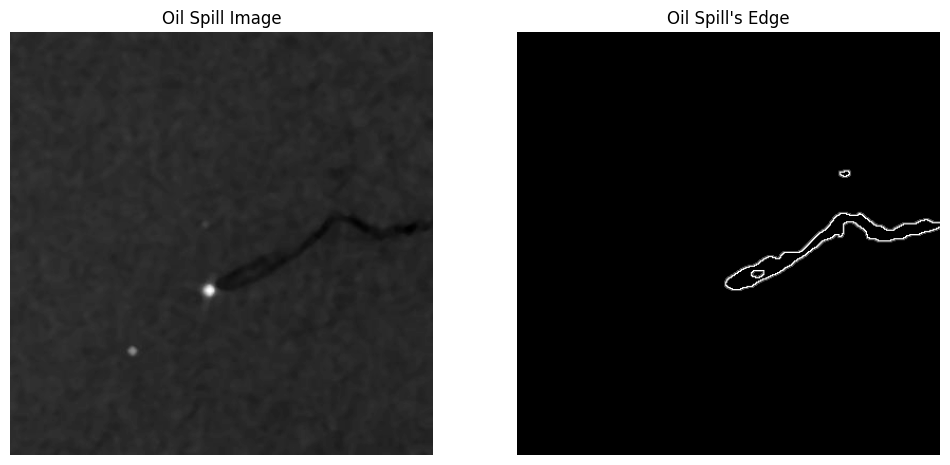

In [34]:
E = edge(segmented.copy())

plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow(original, cmap='gray')
plt.title('Oil Spill Image')
plt.axis('off')

plt.subplot(122)
plt.imshow(E, cmap='gray')
plt.title("Oil Spill's Edge")
plt.axis('off')

# 5) Data Augmentation (Using Rotation)

In [35]:
def generate_transformed_images(image_path, output_folder):
    
    image = Image.open(image_path)
    image_name = os.path.splitext(os.path.basename(image_path))[0]

    transformations = [("r1", lambda img: img),  # Original
                       ("r2", lambda img: img.rotate(90, expand=True)),
                       ("r3", lambda img: img.rotate(180, expand=True)),
                       ("r4", lambda img: img.rotate(270, expand=True)),
                       ("r5", lambda img: ImageOps.mirror(img)),
                       ("r6", lambda img: ImageOps.flip(img)),
                       ("r7", lambda img: ImageOps.mirror(img.rotate(90, expand=True))),
                       ("r8", lambda img: ImageOps.flip(img.rotate(90, expand=True)))]

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for suffix, transform in transformations:
        transformed_img = transform(image)
        filename = f"{image_name}_{suffix}.jpg"
        filepath = os.path.join(output_folder, filename)
        transformed_img.save(filepath)

## <font color="#C70039">Example</font>

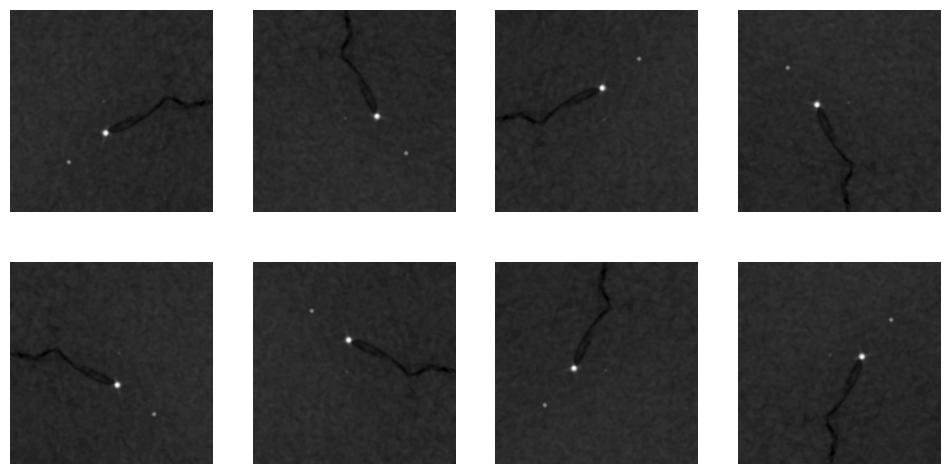

In [36]:
output_folder = r"C:\Users\bassi\Desktop\test"
generate_transformed_images(path, output_folder)

# Displaying the resulting images

L = os.listdir(output_folder)
L = [os.path.join(output_folder, l) for l in L]

plt.figure(figsize=(12, 6))

for k in range(1, 9):
    plt.subplot(2, 4, k)
    A = img_as_float(io.imread(L[k-1], as_gray=True))
    plt.imshow(A, cmap='gray')
    plt.axis('off')

plt.show()

(-0.5, 399.5, 399.5, -0.5)

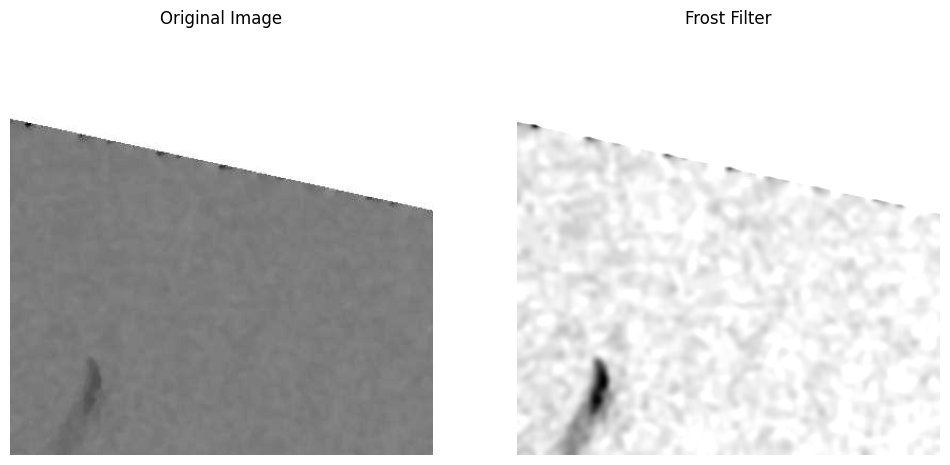

In [44]:
path = r"C:\Users\bassi\ARIAS\OSD\Data\SAR images\alldata\data - Copy\1\1_0089.jpeg"
original2 = io.imread(path, as_gray=True)/255.0

ff = frost_filter(original2.copy())
FF = rmv_brt1(ff.copy(), 0.6,0.6)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(original2, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(122)
plt.imshow(FF, cmap='gray')
plt.title('Frost Filter')
plt.axis('off')

CPU times: total: 78.1 ms
Wall time: 75.9 ms


(-0.5, 399.5, 399.5, -0.5)

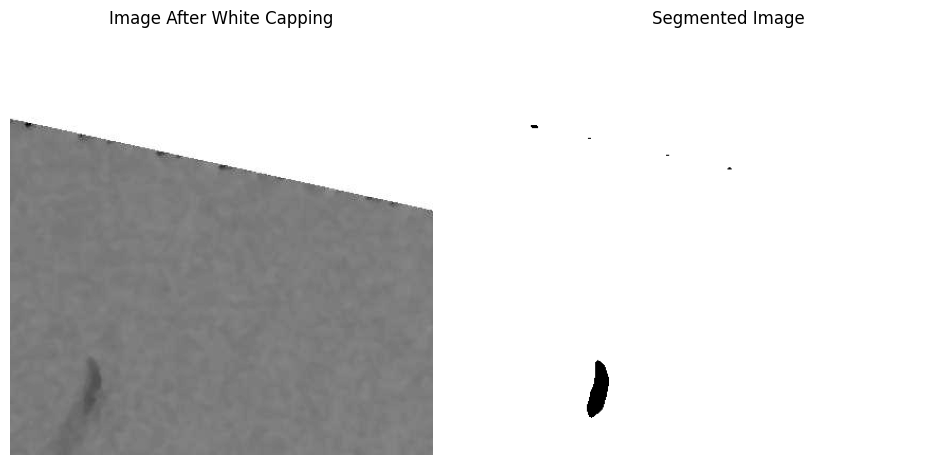

In [45]:
%%time

segmented2 = segment(FF.copy())

plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow(original2, cmap='gray')
plt.title('Image After White Capping')
plt.axis('off')

plt.subplot(122)
plt.imshow(segmented2, cmap='gray')
plt.title('Segmented Image')
plt.axis('off')

(-0.5, 399.5, 399.5, -0.5)

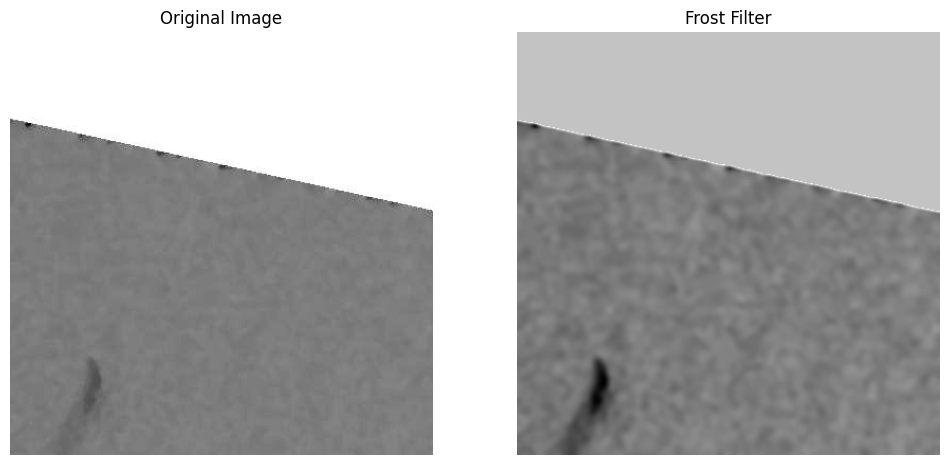

In [46]:
ff = frost_filter(original2.copy())
FF = rmv_brt4(ff.copy())

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(original2, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(122)
plt.imshow(FF, cmap='gray')
plt.title('Frost Filter')
plt.axis('off')

CPU times: total: 46.9 ms
Wall time: 62.3 ms


(-0.5, 399.5, 399.5, -0.5)

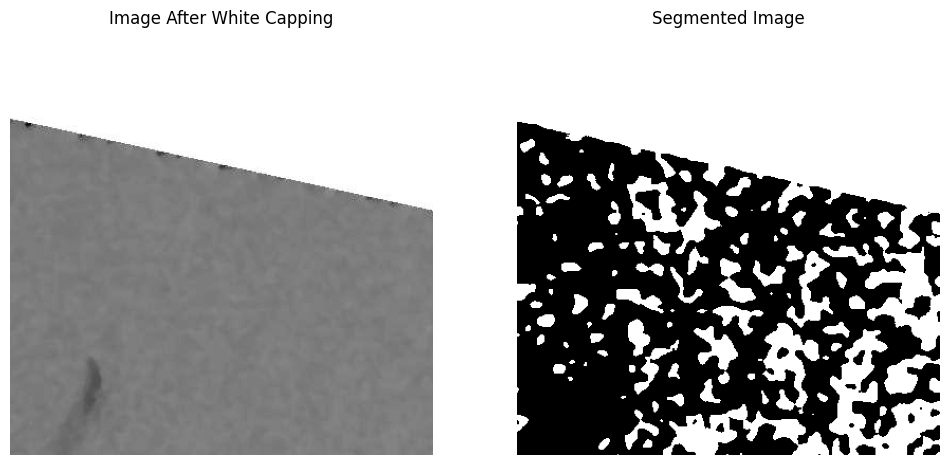

In [47]:
%%time

segmented2 = segment(FF.copy())

plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow(original2, cmap='gray')
plt.title('Image After White Capping')
plt.axis('off')

plt.subplot(122)
plt.imshow(segmented2, cmap='gray')
plt.title('Segmented Image')
plt.axis('off')